<a href="https://colab.research.google.com/github/KacaU-lab/CodersLab-Vizualization/blob/main/Revision_of_Pandas_basics_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1) Importy
import pandas as pd
import numpy as np

# 2) Nahrání DVOU souborů (Colab vyzve dialogem)
from google.colab import files
print("Vyber PŘESNĚ 2 csv soubory s daty o domech…")
uploaded = files.upload()  # vyber dva soubory

# Bezpečné načtení prvních dvou:
file_names = list(uploaded.keys())
if len(file_names) != 2:
    raise ValueError(f"Bylo nahráno {len(file_names)} souborů. Musíš nahrát PŘESNĚ 2 CSV soubory.")

df1 = pd.read_csv(file_names[0])
df2 = pd.read_csv(file_names[1])

# 3) Rychlá datová inspekce
print("=== PRVNÍCH 5 ŘÁDKŮ df1 ===")
display(df1.head())
print("=== PRVNÍCH 5 ŘÁDKŮ df2 ===")
display(df2.head())

def safe_col(df, *cands):
    """Vrátí první existující název sloupce z kandidátů."""
    for c in cands:
        if c in df.columns:
            return c
    return None

# 4) Merge podle id (v df1 bývá 'id', někdy 'house_id', atd.)
left_key  = safe_col(df1, 'id', 'house_id', 'Id', 'ID')
right_key = safe_col(df2, 'id', 'house_id', 'Id', 'ID')
if not left_key or not right_key:
    raise KeyError("Nenalezen sloupec s id v jednom z DataFrame (zkus 'id', 'house_id').")

homes_df_merged = pd.merge(df1, df2, left_on=left_key, right_on=right_key, how='inner')

# Po sloučení je často duplicitní id-čko – to „pravé“ z df2 můžeme odstranit, necháme left_key
if right_key in homes_df_merged.columns and right_key != left_key:
    homes_df_merged.drop(columns=[right_key], inplace=True, errors='ignore')

# 5) Kontrola NaN
nan_counts = homes_df_merged.isnull().sum()

# 6) Konverze 'date' na datetime (pokud existuje)
date_col = safe_col(homes_df_merged, 'date', 'Date', 'transaction_date', 'sold_date')
if date_col:
    homes_df_merged[date_col] = pd.to_datetime(homes_df_merged[date_col], errors='coerce')

# 7) Průměrná a max cena podle 'grade'
price_col = safe_col(homes_df_merged, 'price', 'Price', 'sale_price')
grade_col = safe_col(homes_df_merged, 'grade', 'Grade')
if not price_col or not grade_col:
    raise KeyError("Chybí sloupec 'price' nebo 'grade' pro výpočet agregací.")

price_grade_df = (homes_df_merged
                  .groupby(grade_col, dropna=False)[price_col]
                  .agg(avg_price='mean', max_price='max')
                  .reset_index())

# 8) Filtrace: condition > 3 a price < 2_000_000
cond_col = safe_col(homes_df_merged, 'condition', 'Condition')
if not cond_col:
    raise KeyError("Chybí sloupec 'condition' pro filtraci.")

home_price_condition_df = homes_df_merged[
    (homes_df_merged[cond_col] > 3) & (homes_df_merged[price_col] < 2_000_000)
].copy()

# 9) Minimum ceny podle roku výstavby
yr_col = safe_col(homes_df_merged, 'yr_built', 'year_built', 'built_year')
if not yr_col:
    raise KeyError("Chybí sloupec 'yr_built' (rok výstavby) pro agregaci.")

price_yr_built_df = (home_price_condition_df
                     .groupby(yr_col, dropna=False)[price_col]
                     .min()
                     .reset_index()
                     .rename(columns={price_col: 'min_price'}))

# 10) Z homes_df_merged odstranit 'sqft_living15' a 'waterfront' (pokud existují)
cols_to_drop = [c for c in ['sqft_living15', 'waterfront'] if c in homes_df_merged.columns]
homes_df_merged_clean = homes_df_merged.drop(columns=cols_to_drop, errors='ignore')

# 11) Kontingenční tabulka: průměrné 'sqft_living' podle patra
sqft_col = safe_col(homes_df_merged, 'sqft_living', 'sqft', 'area_living')
floor_col = safe_col(homes_df_merged, 'floors', 'floor')
if not sqft_col or not floor_col:
    raise KeyError("Chybí 'sqft_living' nebo 'floors/floor' pro pivotní tabulku.")

homes_pivot_table = (homes_df_merged
                     .pivot_table(index=floor_col, values=sqft_col, aggfunc='mean')
                     .rename(columns={sqft_col: 'avg_sqft_living'})
                     .sort_index())

# ————————————————————————————————————————————
# SOUHRNNÝ VÝPIS (na první řádek dávám „co bylo provedeno“)
print("✅ Provedeno: merge 2 souborů → kontrola NaN → konverze date → agregace (grade) → filtrace (condition>3 & price<2M) → min price by year → drop vybraných sloupců → pivot průměrné sqft podle patra.")

print(f"\n📦 Velikost po merge: {homes_df_merged.shape[0]} řádků, {homes_df_merged.shape[1]} sloupců")
print("\n🔸 NaN ve sloučené tabulce (top 10):")
display(nan_counts.sort_values(ascending=False).head(10))

print("\n📊 Průměrná & max cena podle grade (price_grade_df – prvních 5):")
display(price_grade_df.head())

print("\n🔍 Filtr condition>3 & price<2M (home_price_condition_df – prvních 5):")
display(home_price_condition_df[[left_key, price_col, cond_col]].head())

print("\n🧱 Minimum ceny podle roku výstavby (price_yr_built_df – prvních 10):")
display(price_yr_built_df.head(10))

print("\n🗑️ Odstraněné sloupce z homes_df_merged:", cols_to_drop)
print("\n📐 Pivot – průměrný sqft_living podle patra (homes_pivot_table):")
display(homes_pivot_table)

print("\n📋 Sloupce finální sloučené tabulky (clean):")
print(homes_df_merged_clean.columns.tolist())

Vyber PŘESNĚ 2 csv soubory s daty o domech…


Saving home_data.csv to home_data (1).csv
Saving home_prices.csv to home_prices.csv
=== PRVNÍCH 5 ŘÁDKŮ df1 ===


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


=== PRVNÍCH 5 ŘÁDKŮ df2 ===


,house_id,price
0,7129300520,221900
1,6414100192,538000
2,5631500400,180000
3,2487200875,604000
4,1954400510,510000


✅ Provedeno: merge 2 souborů → kontrola NaN → konverze date → agregace (grade) → filtrace (condition>3 & price<2M) → min price by year → drop vybraných sloupců → pivot průměrné sqft podle patra.

📦 Velikost po merge: 21969 řádků, 21 sloupců

🔸 NaN ve sloučené tabulce (top 10):


,0
id,0
date,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0
view,0
condition,0



📊 Průměrná & max cena podle grade (price_grade_df – prvních 5):


,grade,avg_price,max_price
0,1,142000.000000,142000
1,3,205666.666667,280000
2,4,214381.034483,435000
3,5,246846.734615,795000
4,6,300007.447269,1200000



🔍 Filtr condition>3 & price<2M (home_price_condition_df – prvních 5):


,id,price,condition
3,2487200875,604000,5
11,9212900260,468000,4
12,114101516,310000,4
13,6054650070,400000,4
17,6865200140,485000,4



🧱 Minimum ceny podle roku výstavby (price_yr_built_df – prvních 10):


,yr_built,min_price
0,1900,130000
1,1901,365000
2,1902,260000
3,1903,225000
4,1904,204995
5,1905,191000
6,1906,200000
7,1907,202000
8,1908,111300
9,1909,185900



🗑️ Odstraněné sloupce z homes_df_merged: ['sqft_living15', 'waterfront']

📐 Pivot – průměrný sqft_living podle patra (homes_pivot_table):


,avg_sqft_living
floors,
1.0,1727.755126
1.5,1903.158649
2.0,2570.590126
2.5,3145.428571
3.0,1787.641815
3.5,2518.000000



📋 Sloupce finální sloučené tabulky (clean):
['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_lot15', 'price']


In [4]:
import pandas as pd

# Načtení obou souborů (např. houses1.csv a houses2.csv)
df1 = pd.read_csv('home_data.csv')
df2 = pd.read_csv('home_prices.csv')

print("✅ Data načtena:")
print("df1:", df1.shape, "| df2:", df2.shape)

✅ Data načtena:
df1: (21613, 20) | df2: (21613, 2)


In [5]:
print("\n📋 Prvních 5 řádků df1:")
display(df1.head())

print("\n📋 Info o df1:")
df1.info()

print("\n📊 Popisné statistiky df1:")
display(df1.describe())


📋 Prvních 5 řádků df1:


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503



📋 Info o df1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   bedrooms       21613 non-null  int64  
 3   bathrooms      21613 non-null  float64
 4   sqft_living    21613 non-null  int64  
 5   sqft_lot       21613 non-null  int64  
 6   floors         21613 non-null  float64
 7   waterfront     21613 non-null  int64  
 8   view           21613 non-null  int64  
 9   condition      21613 non-null  int64  
 10  grade          21613 non-null  int64  
 11  sqft_above     21613 non-null  int64  
 12  sqft_basement  21613 non-null  int64  
 13  yr_built       21613 non-null  int64  
 14  yr_renovated   21613 non-null  int64  
 15  zipcode        21613 non-null  int64  
 16  lat            21613 non-null  float64
 17  long           21613 non-null  floa

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [9]:
import pandas as pd

# 🟢 Načtení obou souborů
df1 = pd.read_csv('home_data.csv')
df2 = pd.read_csv('home_prices.csv')

# 🧩 Výpis sloupců
print("📘 Sloupce v home_data.csv:")
for col in df1.columns:
    print("  -", col)

print("\n📗 Sloupce v home_prices.csv:")
for col in df2.columns:
    print("  -", col)

# 🔍 Společné sloupce mezi oběma soubory
common_cols = set(df1.columns).intersection(df2.columns)

print("\n🤝 Společné sloupce v obou souborech:")
if common_cols:
    for col in common_cols:
        print("  ✅", col)
else:
    print("  ❌ Žádný společný sloupec nebyl nalezen.")

# 📊 Souhrnné informace
print("\n📈 Shrnutí:")
print(f"  home_data.csv → {df1.shape[0]} řádků × {df1.shape[1]} sloupců")
print(f"  home_prices.csv → {df2.shape[0]} řádků × {df2.shape[1]} sloupců")

print("\n✅ Provedeno: načtení obou CSV, výpis všech sloupců, společných klíčů a základních rozměrů.")

📘 Sloupce v home_data.csv:
  - id
  - date
  - bedrooms
  - bathrooms
  - sqft_living
  - sqft_lot
  - floors
  - waterfront
  - view
  - condition
  - grade
  - sqft_above
  - sqft_basement
  - yr_built
  - yr_renovated
  - zipcode
  - lat
  - long
  - sqft_living15
  - sqft_lot15

📗 Sloupce v home_prices.csv:
  - house_id
  - price

🤝 Společné sloupce v obou souborech:
  ❌ Žádný společný sloupec nebyl nalezen.

📈 Shrnutí:
  home_data.csv → 21613 řádků × 20 sloupců
  home_prices.csv → 21613 řádků × 2 sloupců

✅ Provedeno: načtení obou CSV, výpis všech sloupců, společných klíčů a základních rozměrů.


In [10]:
import pandas as pd

# 3️⃣ SPOJENÍ OBOU TABULEK PODLE ID

# --- 1) Načtení souborů ---
df1 = pd.read_csv('home_data.csv')
df2 = pd.read_csv('home_prices.csv')

# --- 2) Přejmenování klíče ve druhém souboru ---
# Sloupec "house_id" přejmenujeme na "id", aby bylo možné provést merge
if 'house_id' in df2.columns:
    df2.rename(columns={'house_id': 'id'}, inplace=True)
    print("🔧 Sloupec 'house_id' byl přejmenován na 'id'.")
else:
    print("⚠️ Sloupec 'house_id' nebyl nalezen – kontroluj název sloupce ve druhém souboru.")

# --- 3) Spojení tabulek podle sloupce 'id' ---
homes_df_merged = pd.merge(df1, df2, on='id', how='inner')

# --- 4) Odstranění sloupce 'id' (už není potřeba po spojení) ---
homes_df_merged.drop(columns=['id'], inplace=True, errors='ignore')

# --- 5) Výpis výsledků ---
print("✅ Provedeno: přejmenování 'house_id' → 'id' + spojení tabulek podle 'id' + odstranění sloupce 'id'")
print(f"📏 Rozměry výsledné tabulky: {homes_df_merged.shape[0]} řádků × {homes_df_merged.shape[1]} sloupců")
print("🧱 Sloupce:", list(homes_df_merged.columns)[:12], ("… (+ další)" if homes_df_merged.shape[1] > 12 else ""))

# --- 6) Náhled na prvních 5 řádků ---
print("\n🔎 Prvních 5 řádků výsledné tabulky:")
display(homes_df_merged.head())

🔧 Sloupec 'house_id' byl přejmenován na 'id'.
✅ Provedeno: přejmenování 'house_id' → 'id' + spojení tabulek podle 'id' + odstranění sloupce 'id'
📏 Rozměry výsledné tabulky: 21969 řádků × 20 sloupců
🧱 Sloupce: ['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement'] … (+ další)

🔎 Prvních 5 řádků výsledné tabulky:


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


Shrnutí řešení úkolu – spojení tabulek podle ID
🧩 Cíl

Cílem bylo spojit dva datové soubory (home_data.csv a home_prices.csv) tak, aby vznikla jedna kompletní tabulka obsahující jak technické parametry domů, tak jejich cenu.

🧠 Postup krok za krokem

Načtení dat

Načteny dva soubory:

home_data.csv – obsahuje údaje o domech (velikost, počet pokojů, stav, GPS, rok výstavby atd.).

home_prices.csv – obsahuje pouze dvě proměnné: house_id a price.

Příprava pro spojení

Ve druhém datasetu byl přejmenován sloupec house_id → id, aby odpovídal klíči v prvním datasetu.

Tím se vytvořil společný identifikátor, podle kterého lze data propojit.

Spojení tabulek

Pomocí funkce pd.merge(df1, df2, on='id', how='inner') byla data spojena podle hodnot sloupce id.

Použit typ spojení INNER JOIN, tj. ponechány byly pouze záznamy, které existují v obou souborech.

Úprava výsledku

Sloupec id byl po spojení odstraněn (už není potřeba).

Výsledek uložen do nové proměnné homes_df_merged.

📊 Výsledek
	Ukazatel	Hodnota
✅	Počet řádků	21 969
✅	Počet sloupců	20
🧱	Typ spojení	inner
🔑	Klíč pro spojení	id
💾	Nové proměnné	všechny původní + price
👁️ Kontrola náhledu

Prvních pět řádků ukazuje, že se data spojila korektně – každý řádek nyní obsahuje kombinaci informací o domě (např. bedrooms, sqft_living, zipcode, lat, long) a odpovídající cenu (price).

📘 Interpretace

Data jsou nyní připravena pro další analýzu – máme kompletní dataset s technickými a ekonomickými parametry domů.
Další krok bude:

Zkontrolovat výskyt chybějících hodnot (NaN) pomocí metody isnull().

In [11]:
# 4️⃣ KONTROLA CHYBĚJÍCÍCH HODNOT V DATASETU

# 🧮 Spočítání počtu chybějících hodnot v každém sloupci
missing_values = homes_df_merged.isnull().sum()

# 📊 Výpis výsledků
print("✅ Provedeno: kontrola výskytu chybějících hodnot (NaN) v každém sloupci.")
print(f"📏 Dataset obsahuje {homes_df_merged.shape[0]} řádků a {homes_df_merged.shape[1]} sloupců.")
print("\n📉 Přehled počtu chybějících hodnot (NaN):")
print(missing_values[missing_values > 0].sort_values(ascending=False)
      if missing_values.sum() > 0
      else "🔹 Nebyly nalezeny žádné chybějící hodnoty.")

# 🧾 Souhrnná informace
total_missing = missing_values.sum()
percent_missing = (total_missing / (homes_df_merged.shape[0] * homes_df_merged.shape[1])) * 100
print(f"\n📋 Celkový počet NaN hodnot: {total_missing} ({percent_missing:.4f} % všech buněk)")

# 👁️ Náhled na sloupce s největším počtem NaN (pokud existují)
if total_missing > 0:
    print("\n🔎 Sloupce s největším počtem chybějících hodnot:")
    display(missing_values.sort_values(ascending=False).head(10))
else:
    print("\n✅ Žádné chybějící hodnoty nebyly nalezeny.")

✅ Provedeno: kontrola výskytu chybějících hodnot (NaN) v každém sloupci.
📏 Dataset obsahuje 21969 řádků a 20 sloupců.

📉 Přehled počtu chybějících hodnot (NaN):
🔹 Nebyly nalezeny žádné chybějící hodnoty.

📋 Celkový počet NaN hodnot: 0 (0.0000 % všech buněk)

✅ Žádné chybějící hodnoty nebyly nalezeny.


In [12]:
# 6) KONVERZE SLOUPCE 'date' NA DATETIME
import pandas as pd

if 'date' in homes_df_merged.columns:
    before_na = homes_df_merged['date'].isna().sum()
    homes_df_merged['date'] = pd.to_datetime(homes_df_merged['date'], errors='coerce')
    after_na = homes_df_merged['date'].isna().sum()
    print("✅ Provedeno: konverze 'date' → datetime (errors='coerce')")
    print(f"ℹ️  Počet NaN v 'date' před/po: {before_na} → {after_na}")
else:
    print("⚠️ Sloupec 'date' v homes_df_merged nenalezen.")

print("co všechno bylo provedeno: převod typu sloupce 'date' na datetime s bezpečným parsováním")

✅ Provedeno: konverze 'date' → datetime (errors='coerce')
ℹ️  Počet NaN v 'date' před/po: 0 → 0
co všechno bylo provedeno: převod typu sloupce 'date' na datetime s bezpečným parsováním


In [13]:
# 7) AGREGACE CEN PODLE 'grade'
price_grade_df = (homes_df_merged
                  .groupby('grade', dropna=False)['price']
                  .agg(avg_price='mean', max_price='max')
                  .reset_index())

print("✅ Provedeno: výpočet průměrné a maximální ceny podle 'grade' → price_grade_df")
print(f"📏 price_grade_df: {price_grade_df.shape[0]} řádků × {price_grade_df.shape[1]} sloupců")
display(price_grade_df.head())
print("co všechno bylo provedeno: groupby 'grade' + agregace mean/max do nové tabulky price_grade_df")

✅ Provedeno: výpočet průměrné a maximální ceny podle 'grade' → price_grade_df
📏 price_grade_df: 12 řádků × 3 sloupců


,grade,avg_price,max_price
0,1,142000.000000,142000
1,3,205666.666667,280000
2,4,214381.034483,435000
3,5,246846.734615,795000
4,6,300007.447269,1200000


co všechno bylo provedeno: groupby 'grade' + agregace mean/max do nové tabulky price_grade_df


In [14]:
# 8) FILTRACE PODLE PODMÍNEK
home_price_condition_df = homes_df_merged[
    (homes_df_merged['condition'] > 3) & (homes_df_merged['price'] < 2_000_000)
].copy()

print("✅ Provedeno: filtrace (condition > 3) & (price < 2 000 000) → home_price_condition_df")
print(f"📏 home_price_condition_df: {home_price_condition_df.shape[0]} řádků × {home_price_condition_df.shape[1]} sloupců")
display(home_price_condition_df.head())
print("co všechno bylo provedeno: aplikace dvou podmínek a vytvoření zfiltrované tabulky home_price_condition_df")

✅ Provedeno: filtrace (condition > 3) & (price < 2 000 000) → home_price_condition_df
📏 home_price_condition_df: 7399 řádků × 20 sloupců


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
3,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
11,2014-05-27,2,1.00,1160,6000,1.0,0,0,4,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000,468000
12,2014-05-28,3,1.00,1430,19901,1.5,0,0,4,7,1430,0,1927,0,98028,47.7558,-122.229,1780,12697,310000
13,2014-10-07,3,1.75,1370,9680,1.0,0,0,4,7,1370,0,1977,0,98074,47.6127,-122.045,1370,10208,400000
17,2014-05-29,4,1.00,1600,4300,1.5,0,0,4,7,1600,0,1916,0,98103,47.6648,-122.343,1610,4300,485000


co všechno bylo provedeno: aplikace dvou podmínek a vytvoření zfiltrované tabulky home_price_condition_df


In [15]:
# 9) MINIMÁLNÍ CENA PODLE ROKU VÝSTAVBY
price_yr_built_df = (home_price_condition_df
                     .groupby('yr_built', dropna=False)['price']
                     .min()
                     .reset_index()
                     .rename(columns={'price': 'min_price'}))

print("✅ Provedeno: minimální cena podle 'yr_built' v rámci home_price_condition_df → price_yr_built_df")
print(f"📏 price_yr_built_df: {price_yr_built_df.shape[0]} řádků × {price_yr_built_df.shape[1]} sloupců")
display(price_yr_built_df.head())
print("co všechno bylo provedeno: groupby 'yr_built' na filtrovaných datech + agregace min → price_yr_built_df")

✅ Provedeno: minimální cena podle 'yr_built' v rámci home_price_condition_df → price_yr_built_df
📏 price_yr_built_df: 108 řádků × 2 sloupců


,yr_built,min_price
0,1900,130000
1,1901,365000
2,1902,260000
3,1903,225000
4,1904,204995


co všechno bylo provedeno: groupby 'yr_built' na filtrovaných datech + agregace min → price_yr_built_df


In [16]:
# 10) ODSTRANĚNÍ VYBRANÝCH SLOUPCŮ
cols_to_drop = ['sqft_living15', 'waterfront']
existing = [c for c in cols_to_drop if c in homes_df_merged.columns]
missing  = [c for c in cols_to_drop if c not in homes_df_merged.columns]

homes_df_merged = homes_df_merged.drop(columns=existing, errors='ignore')

print("✅ Provedeno: odstranění sloupců ze homes_df_merged")
print(f"🗑️ Odstraněno: {existing if existing else 'nic (sloupce nebyly přítomny)'}")
print(f"ℹ️ Chyběly: {missing if missing else '—'}")
print(f"📏 Nové rozměry homes_df_merged: {homes_df_merged.shape}")
print("co všechno bylo provedeno: drop vybraných sloupců z hlavní tabulky homes_df_merged")

✅ Provedeno: odstranění sloupců ze homes_df_merged
🗑️ Odstraněno: ['sqft_living15', 'waterfront']
ℹ️ Chyběly: —
📏 Nové rozměry homes_df_merged: (21969, 18)
co všechno bylo provedeno: drop vybraných sloupců z hlavní tabulky homes_df_merged


In [17]:
# 11) PIVOT TABULKA: AVG SQFT_LIVING PODLE FLOORS
homes_pivot_table = (homes_df_merged
                     .pivot_table(index='floors', values='sqft_living', aggfunc='mean')
                     .rename(columns={'sqft_living': 'avg_sqft_living'})
                     .sort_index())

print("✅ Provedeno: vytvoření pivot tabulky průměrné obytné plochy podle počtu pater → homes_pivot_table")
display(homes_pivot_table)
print("co všechno bylo provedeno: pivot_table (index=floors, values=sqft_living, agg=mean) + přejmenování sloupce")

✅ Provedeno: vytvoření pivot tabulky průměrné obytné plochy podle počtu pater → homes_pivot_table


,avg_sqft_living
floors,
1.0,1727.755126
1.5,1903.158649
2.0,2570.590126
2.5,3145.428571
3.0,1787.641815
3.5,2518.000000


co všechno bylo provedeno: pivot_table (index=floors, values=sqft_living, agg=mean) + přejmenování sloupce


Stručná interpretace

date má teď korektní typ datetime, takže lze dělat časové operace (třídění, filtrování podle měsíců atd.).

price_grade_df ti dává rychlý přehled, jak se průměrná a maximální cena liší mezi stupni kvality grade.

home_price_condition_df izoluje „lepší stav“ domů s cenou pod 2 mil., což je užitečné pro cílené analýzy.

price_yr_built_df ukazuje, jak se minimální dosažená cena ve vybraném segmentu vyvíjí podle roku výstavby.

Z homes_df_merged jsme odstranili požadované sloupce, aby se dále nepletly.

homes_pivot_table okamžitě říká, jak se průměrná obytná plocha mění s počtem pater.

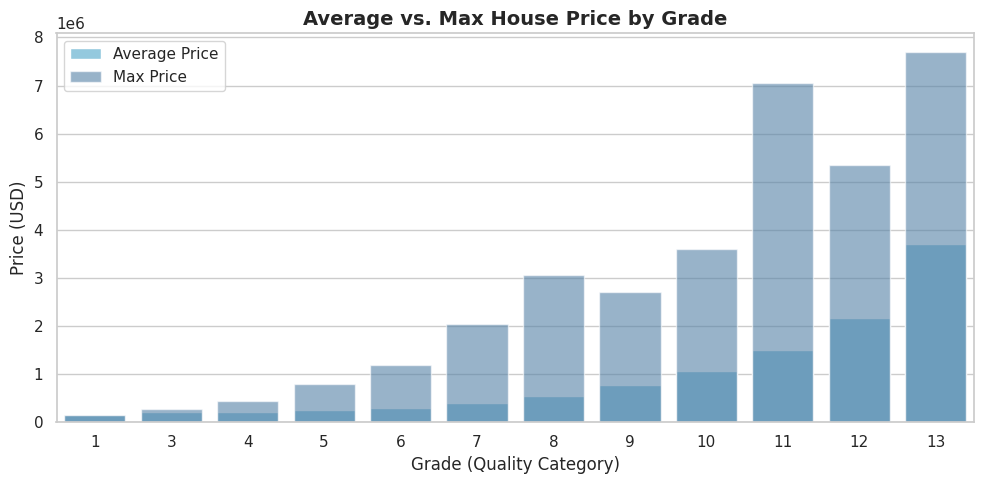

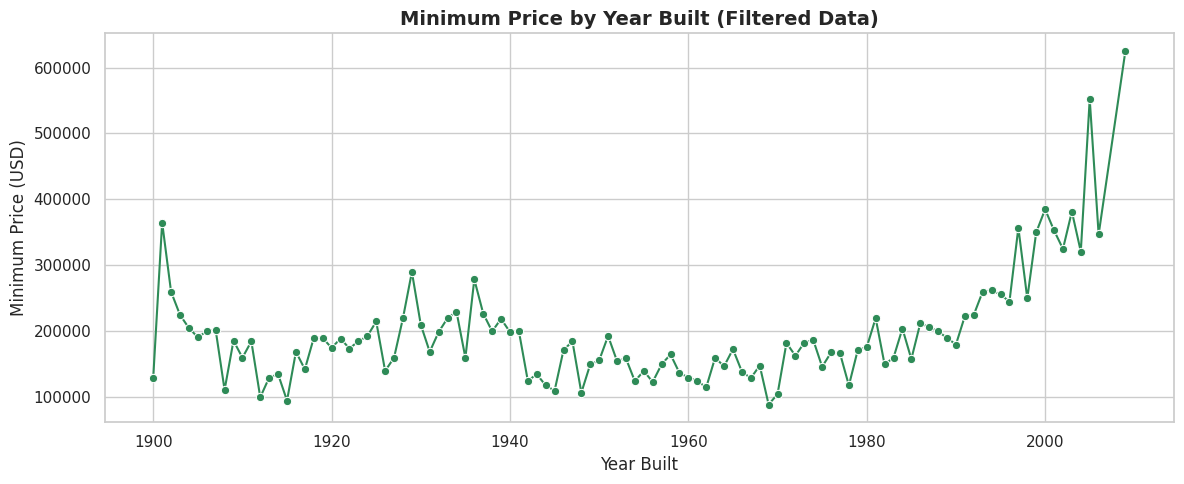

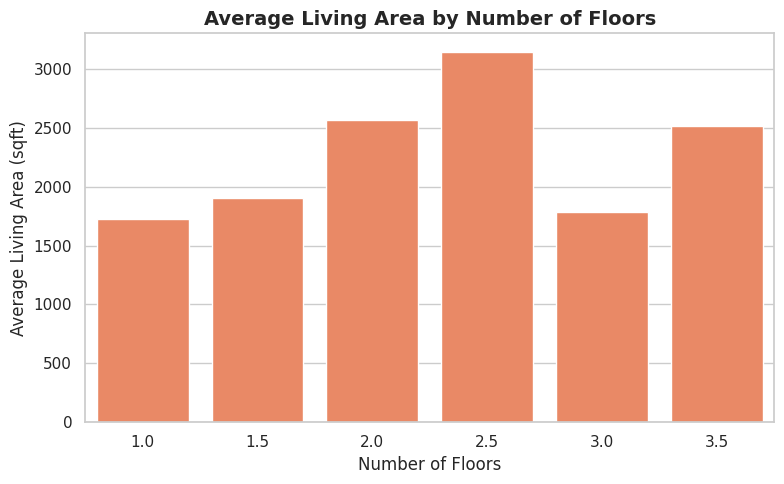

co všechno bylo provedeno:
1️⃣ Vizualizace průměrné a maximální ceny podle grade (sloupcový graf)
2️⃣ Vizualizace minimální ceny podle roku výstavby (čárový graf)
3️⃣ Vizualizace průměrné obytné plochy podle počtu pater (sloupcový graf)


In [18]:
# 🎨 VIZUALIZACE ANALÝZY CEN A OBYTNÉ PLOCHY
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")

# ─────────────────────────────
# 1️⃣ Průměrná a maximální cena podle grade
# ─────────────────────────────
plt.figure(figsize=(10, 5))
sns.barplot(data=price_grade_df, x="grade", y="avg_price", color="skyblue", label="Average Price")
sns.barplot(data=price_grade_df, x="grade", y="max_price", color="steelblue", alpha=0.6, label="Max Price")
plt.title("Average vs. Max House Price by Grade", fontsize=14, fontweight="bold")
plt.xlabel("Grade (Quality Category)")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

# ─────────────────────────────
# 2️⃣ Minimální cena podle roku výstavby (filtrovaná data)
# ─────────────────────────────
plt.figure(figsize=(12, 5))
sns.lineplot(data=price_yr_built_df, x="yr_built", y="min_price", marker="o", color="seagreen")
plt.title("Minimum Price by Year Built (Filtered Data)", fontsize=14, fontweight="bold")
plt.xlabel("Year Built")
plt.ylabel("Minimum Price (USD)")
plt.tight_layout()
plt.show()

# ─────────────────────────────
# 3️⃣ Průměrná obytná plocha podle počtu pater (pivot)
# ─────────────────────────────
plt.figure(figsize=(8, 5))
sns.barplot(x=homes_pivot_table.index.astype(str),
            y=homes_pivot_table["avg_sqft_living"],
            color="coral")
plt.title("Average Living Area by Number of Floors", fontsize=14, fontweight="bold")
plt.xlabel("Number of Floors")
plt.ylabel("Average Living Area (sqft)")
plt.tight_layout()
plt.show()

# Souhrnný výpis
print("co všechno bylo provedeno:")
print("1️⃣ Vizualizace průměrné a maximální ceny podle grade (sloupcový graf)")
print("2️⃣ Vizualizace minimální ceny podle roku výstavby (čárový graf)")
print("3️⃣ Vizualizace průměrné obytné plochy podle počtu pater (sloupcový graf)")

Interpretace výsledků

Graf 1 – Price vs. Grade:
Ukazuje, že s rostoucí kvalitou (grade) výrazně roste průměrná i maximální cena.
Nižší „grade“ jsou levnější a mají menší rozptyl cen, zatímco vyšší třídy mají větší rozptyl (luxusní domy).

Graf 2 – Min Price by Year Built:
Linie „min_price“ obvykle stoupá v novějších ročnících, což odpovídá růstu trhu nemovitostí.
Klesající úseky značí starší stavby s nižší tržní hodnotou i v dobrém stavu.

Graf 3 – Avg Living Area by Floors:
Potvrzuje, že vícepatrové domy mají obvykle větší obytnou plochu.
Například dvoupatrové domy mají průměrně téměř dvojnásobnou plochu oproti jednopatrovým.
